# Fitting Emission Lines with Prospector: Multiple Lines Proof of Concept

This notebook extends the single line proof-of-concept to multiple lines.

## Environment

Let's initialize the environment.

In [1]:
import time, sys, os
from pandas.tools.plotting import autocorrelation_plot # autocorrelation plot
import corner

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Basic Idea

Let's define our emission line model, which reads a series of lists of a each line's mean, standard deviation, and amplitude 

$$ \boldsymbol{\theta} = \lbrace \boldsymbol{\theta}_i \rbrace = \lbrace \mu_i, \sigma_i, \alpha_i \rbrace $$ 

and models the resulting emission as a sum of Gaussians such that

$$ 
\mathbf{F}(\boldsymbol{\theta}) = \sum_i \mathbf{F}_i(\boldsymbol{\theta}_i) 
= \sum_i \alpha_i \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu_i, \sigma_i^2)
$$

In [2]:
# Normal/Gaussian
def gaussian(mu, std, x):    
    dif = x - mu
    norm = 1. / sqrt(2*pi) / std
    return norm * exp(-0.5 * square(dif/std))

# emission line model
def emline(theta):
    mu, sigma, alpha = theta
    return alpha * gaussian(mu, sigma, x)

# combination of emission lines
def emlines(thetas, return_lines=False):
    thetas = array(thetas).reshape(-1,3)
    lines = array([emline(theta) for theta in thetas])
    if return_lines: 
        return lines.sum(axis=0), lines
    else:
        return lines.sum(axis=0)

Our toy model here is a bunch of slightly overlapping noisy emission lines.

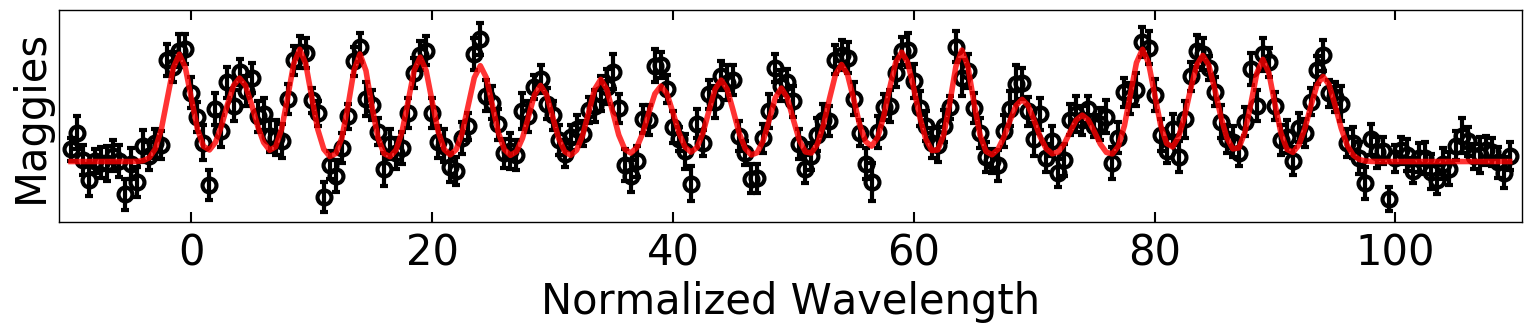

In [3]:
# initialize observing properties
x = arange(-10, 110, 0.5) # wavelength grid
noise = 10. # background noise

# initialize single line properties
mu, sigma, alpha = 0., 1., 150. # standard parameters of our fit: mean, standard deviation, and amplitude
theta_true = array([mu, sigma, alpha])

# initialize ensemble of lines
Nlines = 20
Ntheta, Ndata = Nlines*3, len(x) # number of parameters, data points
thetas_true = tile(theta_true, Nlines) # tile parameters
thetas_true[0::3] = arange(0, 100, 5.) # initialize varying means
thetas_true[0::3] -= 1. # shift mu
thetas_true[1::3] += normal(0., 0.1, size=Nlines) # add some jitter in sigma
thetas_true[2::3] += normal(0., 30., size=Nlines) # add some jitter in alpha

# initialize noiseless and noisy data
y = emlines(thetas_true)
y_err = normal(noise, size=Ndata)
y_obs = normal(y, y_err)

figure(figsize=(16,4))
errorbar(x, y_obs, yerr=y_err, marker='o', markerfacecolor='none', markeredgecolor='black', markeredgewidth=3,
         markersize=10, ecolor='black', lw=3, linestyle='None')
plot(x, y, lw=4, alpha=0.8, color='red')
xlim([x.min()-1, x.max()+1])
yticks([])
xlabel('Normalized Wavelength')
ylabel('Maggies')
tight_layout()

As before, our likelihood is simply

$$ P(\mathbf{\hat{F}} \,|\, \boldsymbol{\theta}) = \mathcal{N}\left[\Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) \:|\: \mathbf{0}, \mathbf{\hat{C}} \right] $$

where $\Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) \equiv \mathbf{F}(\boldsymbol{\theta}) - \mathbf{\hat{F}}$. The corresponding log-likelihood is then

$$ \ln P(\mathbf{\hat{F}} \,|\, \boldsymbol{\theta}) = -\frac{1}{2}\Delta\mathbf{\hat{F}}(\boldsymbol{\theta})^T \mathbf{\hat{C}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) + Z_{\mathbf{\hat{F}}} $$

where $Z_{\mathbf{\hat{F}}}$ is a normalization constant.

If we assume a (multivariate) Normal prior on $\boldsymbol{\theta}$ with mean $\boldsymbol{\mu}_{\boldsymbol{\theta}}$ and covariance $\mathbf{C}_{\boldsymbol{\theta}}$ such that

$$ P(\boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\theta} \,|\, \boldsymbol{\mu}_{\boldsymbol{\theta}}, \mathbf{C}_{\boldsymbol{\theta}}) \quad, $$

our posterior then simply becomes 

$$ \ln P(\boldsymbol{\theta} \,|\, \mathbf{\hat{F}}) = -\frac{1}{2} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta})^T \mathbf{\hat{C}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) + Z_{\mathbf{\hat{F}}} -\frac{1}{2} \Delta\boldsymbol{\theta}^T \mathbf{C}_{\boldsymbol{\theta}}^{-1} \Delta\boldsymbol{\theta} + Z_{\boldsymbol{\theta}} $$

where $\Delta\boldsymbol{\theta} \equiv \boldsymbol{\mu}_{\boldsymbol{\theta}} - \boldsymbol{\theta}$.

In [4]:
# prior parameters
mean_theta = tile(theta_true, Nlines)
mean_theta[0::3] = arange(0, 100, 5.) # mean is initial theta without the noise or shift
cov_theta = diag(tile([2., 0.25, 50.], Nlines)**2) # covariance is diagonal with std = (2, 0.25, and 50) for each line
prec_theta = inv(cov_theta) # precision matrix

# data parameters
mean_data, cov_data = y_obs, diag(y_err**2) # vector and matrix form for the data
prec_data = inv(cov_data) # precision matrix

For completeness, we note that our constants are equal to

$$ 
Z_{\mathbf{\hat{F}}} = -\frac{1}{2} ( N_{\mathbf{\hat{F}}} \ln 2\pi + \ln|\mathbf{\hat{C}}| ) \quad , \quad 
Z_{\boldsymbol{\theta}} = -\frac{1}{2} ( N_{\boldsymbol{\theta}} \ln 2\pi + \ln|\mathbf{C}_{\boldsymbol{\theta}}| ) \quad .
$$

To evaluate the log-determinant, we will take advantage of **Cholesky decomposition** to decompose our covariance matrix such that the log-determinant simply becomes

$$ \ln|\mathbf{C}| = \ln|\mathbf{L} \mathbf{L}^T| = \ln |\mathbf{L}|^2 = 2\ln \left[ \prod_i L_{ii} \right] = 2 \sum_i \ln L_{ii} \quad .$$

In [5]:
# constants
cov_cho_theta = linalg.cholesky(cov_theta) # cholesky decomposition
lnorm_theta = -0.5*(Ntheta*log(2*pi) + 2*sum(log(diag(cov_cho_theta)))) # compute ln(norm)

cov_cho_data = linalg.cholesky(cov_data) # cholesky decomposition
lnorm_data = -0.5*(Ndata*log(2*pi) + 2*sum(log(diag(cov_cho_data)))) # compute ln(norm)

In [6]:
# ln(prior)
def lnprior(theta):
    dtheta = theta - mean_theta
    sqdist = dot(dot(dtheta.T, prec_theta), dtheta)
    return -0.5*sqdist + lnorm_theta

# ln(likelikehood)
def lnlike(theta):
    model = emlines(theta)
    delta = model - mean_data
    sqdist = dot(dot(delta.T, prec_data), delta)
    return -0.5*sqdist + lnorm_data

# define ln(posterior)
def lnpost(theta):
    return lnlike(theta) + lnprior(theta)

In [20]:
# ln(prior) gradient
def lnprior_grad(theta):
    dtheta = theta - mean_theta
    grad = dot(prec_theta, dtheta)
    return -grad

# ln(likelikehood) gradient
def lnlike_grad(theta):
    model, lines = emlines(theta, return_lines=True) # grab emline model + individual line models
    delta = model - mean_data # compute dF
    model_matrix = tile(lines, 3).reshape(Ntheta, Ndata) # compute first part of G (line flux tiling)
    mu_arr, sigma_arr, alpha_arr = theta.reshape(-1,3).T # grab line parameters
    dx_matrix = (x[:,None] - mu_arr).T # lambda - mu matrix
    deriv_matrix = array([[sigma_arr[i]**-2 * dx_matrix[i], 
                           sigma_arr[i]**-3 * dx_matrix[i]**2 - sigma_arr[i]**-1, 
                           alpha_arr[i]**-1 * ones(Ndata)]
                          for i in xrange(Nlines)]).reshape(Ntheta, Ndata) # compute second part of G (model params tiling)
    res_matrix = deriv_matrix * model_matrix # compute G
    grad = dot(dot(res_matrix, prec_data), delta) # compute gradient
    return -grad

# ln(posterior) gradient
def lnpost_grad(theta):
    return lnlike_grad(theta) + lnprior_grad(theta)

## Standard Approach: Optimization

We can easily attempt to find the *maximum a posteriori* (MAP) solution using a minimization routine, as shown below.

In [18]:
from scipy.optimize import minimize

MAP solution: [  -0.99202077    0.9648446   187.96507125    4.22547503    1.2900989
  182.8904287     9.04178147    0.87243562  169.25488151   13.99381228
    0.80264901  143.22064527   19.07349703    0.81603861  151.94958939
   24.01424699    0.81161283  147.19531129   28.88409528    1.06790155
  136.97078424   34.15061681    1.1328528   151.85483779   38.89404213
    0.86058716  136.9671311    44.05838114    1.01087869  149.85817323
   48.99532774    0.86270597  134.71933974   54.016333      0.89773573
  165.03263476   59.15151839    1.12703985  203.02896877   63.9320587
    0.92542679  157.50013712   68.85775111    0.97155729  121.57866256
   74.38710388    1.17422442  100.23033595   78.96896326    1.02866551
  185.98833633   83.92652093    1.04088193  192.98414782   88.94805145
    1.02422038  166.57493992   94.02693446    1.11581097  172.22257377]
Truth: [  -1.            0.96448554  170.77545946    4.            1.14973256
  158.27440727    9.            0.94665287  175.34109432 

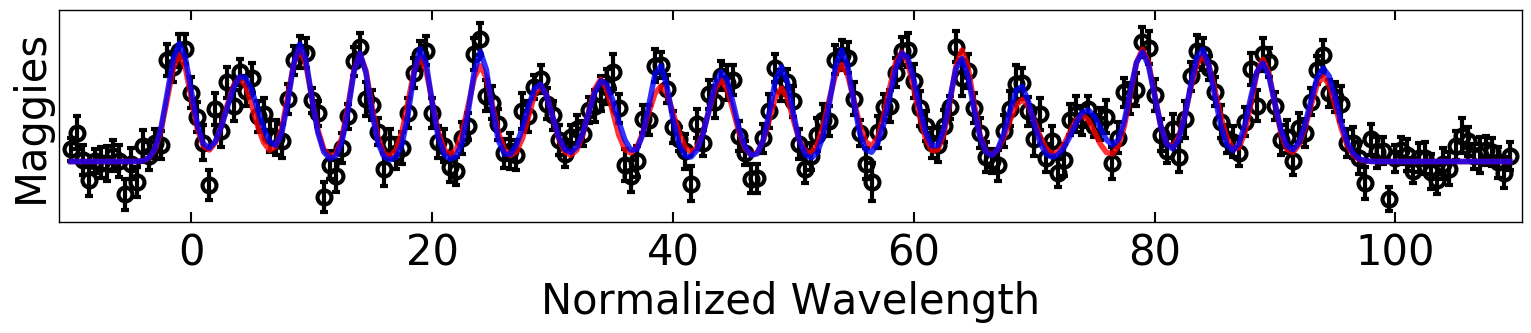

In [31]:
def neglnpost(theta):
    return -lnpost(theta)

def neglnpost_grad(theta):
    return -lnpost_grad(theta)

results = minimize(neglnpost, mean_theta, jac=neglnpost_grad)

figure(figsize=(16,4))
errorbar(x, y_obs, yerr=y_err, marker='o', markerfacecolor='none', markeredgecolor='black', markeredgewidth=3,
         markersize=10, ecolor='black', lw=3, linestyle='None')
plot(x, y, lw=4, alpha=0.8, color='red')
plot(x, emlines(results.x), lw=4, alpha=0.8, color='blue')
xlim([x.min()-1, x.max()+1])
yticks([])
xlabel('Normalized Wavelength')
ylabel('Maggies')
tight_layout()

print 'MAP solution: {0}'.format(results.x)
print 'Truth: {0}'.format(thetas_true)

In [179]:
mass_inv = results.hess_inv # inverse mass = inverse hessian
mass = inv(mass_inv) # mass = hessian

## Probing the Posterior with Hamiltonian Monte Carlo

We are interested in probing the full posterior, not just the MAP solution. As before, we use **Hamiltonian Monte Carlo (HMC)** to take advantage of the fact that (1) our likelihood surface is smooth, (2) the gradients are analytic, and (3) the scaling with dimensionality is quite good.

### Hamiltonian Dynamics

In brief, we can sample from the distribution by simulating a particle "rolling" around the potential with position $\mathbf{q}$ and momentum $\mathbf{p}$ such that 

$$ P(\mathbf{q}, \mathbf{p}) = \frac{1}{Z} \exp\left[ -\frac{H(\mathbf{q}, \mathbf{p})}{T} \right] = \frac{1}{Z} \exp\left[ -\frac{U(\mathbf{q})}{T} \right] \exp\left[ -\frac{K(\mathbf{p})}{T} \right] $$

where the Hamiltonian $H(\mathbf{q},\mathbf{p}) = U(\mathbf{q}) + K(\mathbf{p})$ is just a sum over the potential energy $U(\mathbf{q})$ and kinetic energy $K(\mathbf{p})$ of the particle, $T$ is the temperature of the system, and $Z$ is a normalizing constant.

Letting:
- our position $\mathbf{q} \equiv \boldsymbol{\theta}$ be our parameters of interest, 
- our momentum $\mathbf{p} \equiv \mathbf{M} \boldsymbol{\dot{\theta}}$ be the change in our parameters of interest multiplied by a **mass matrix** $\mathbf{M}$, 
- our potential energy $U(\mathbf{q}) = −\ln P(\mathbf{q} \,|\, \mathbf{\hat{F}}) $ be the negative log of our posterior, 
- and our kinetic energy $K(p) = \frac{1}{2} \mathbf{p}^T \mathbf{M}^{-1} \mathbf{p}$ be in a standard quadratic form, 

we get

$$ P(\mathbf{q}, \mathbf{p}) \propto \exp\left[ -\frac{1}{2} \mathbf{p}^T \mathbf{M}^{-1} \mathbf{p} \right] \, P(\mathbf{q} \,|\, \mathbf{\hat{F}}) $$

where we have set $T=1$.

Since the Hamiltonian is conserved, the system evolves according to Hamilton's equations such that

$$ 
\frac{\partial \mathbf{q}}{\partial t} = \nabla_{\mathbf{p}} K = \mathbf{M}^{-1} \mathbf{p} \quad , \quad 
\frac{\partial \mathbf{p}}{\partial t} = - \nabla_{\mathbf{q}} U = \nabla_{\mathbf{q}} \ln P( \mathbf{q} \,|\, \mathbf{\hat{F}})
$$

where $U(\boldsymbol{\theta})$ is defined as above. 

### Our Potential/Posterior Gradients

In our original notation, the gradient of our log-posterior can be written as

$$ \nabla_{\boldsymbol{\theta}} \ln P(\boldsymbol{\theta} \,|\, \mathbf{\hat{F}}) = -\nabla_{\boldsymbol{\theta}} \mathbf{F}(\boldsymbol{\theta})^T \mathbf{\hat{C}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) - \nabla_{\boldsymbol{\theta}} \boldsymbol{\theta}^T \mathbf{C}_{\boldsymbol{\theta}}^{-1} \Delta\boldsymbol{\theta} \quad . $$

Given that $\mathbf{F}(\boldsymbol{\theta} = \lbrace \mu_i, \sigma_i, \alpha_i \rbrace) = \sum_i \mathbf{F}_i(\boldsymbol{\theta}_i) = \sum_i \alpha_i \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu_i, \sigma_i^2)$, the partials for each component can be written as:

$$
\frac{\partial \mathbf{F}}{\partial \mu_i} = \sigma_i^{-2} (\boldsymbol{\lambda} - \mu_i) \bullet \alpha_i \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu_i, \sigma_i^2) 
= \boxed{ \sigma_i^{-2} (\boldsymbol{\lambda} - \mu_i) \bullet \mathbf{F}_i(\boldsymbol{\theta}_i) } \\
\frac{\partial \mathbf{F}}{\partial \sigma_i} = (\sigma_i^{-3} (\boldsymbol{\lambda} - \mu_i)^2 - \sigma_i^{-1}) \bullet \alpha_i \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu_i, \sigma_i^2) 
= \boxed{ (\sigma_i^{-3} (\boldsymbol{\lambda} - \mu_i)^2 - \sigma_i^{-1}) \bullet \mathbf{F}_i(\boldsymbol{\theta}_i) } \\
\frac{\partial \mathbf{F}}{\partial \alpha_i} = \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu_i, \sigma_i^2) 
= \boxed{ \alpha_i^{-1} \bullet \mathbf{F}_i(\boldsymbol{\theta}_i) }
$$

where $\bullet$ indicates element-wise multiplication (i.e. the Hadamard product). Since by definition the gradient of $\boldsymbol{\theta}$ with respect to $\boldsymbol{\theta}$ is just the identity matrix, after defining

$$ 
\mathbf{G}(\boldsymbol{\theta}) \equiv 
\begin{bmatrix}
\vdots \\
\underline{\mathbf{F}}_i(\boldsymbol{\theta}_i) \bullet \mathbf{J}_i(\boldsymbol{\theta}_i) \\
\vdots
\end{bmatrix} \quad , \quad
\underline{\mathbf{F}}_i(\boldsymbol{\theta}_i) \equiv 
\begin{bmatrix}
\mathbf{F}_i(\boldsymbol{\theta}_i) \\
\mathbf{F}_i(\boldsymbol{\theta}_i) \\
\mathbf{F}_i(\boldsymbol{\theta}_i)
\end{bmatrix} \quad , \quad
\mathbf{J}_i(\boldsymbol{\theta}_i) \equiv
\begin{bmatrix}
\sigma_i^{-2} (\boldsymbol{\lambda} - \mu_i) \\
\sigma_i^{-3} (\boldsymbol{\lambda} - \mu_i)^2 - \sigma_i^{-1} \\
\alpha_i^{-1} \mathbf{1}
\end{bmatrix}
$$

our gradient can be written as

$$ \nabla_{\boldsymbol{\theta}} \ln P(\boldsymbol{\theta} \,|\, \mathbf{\hat{F}}) = - \mathbf{G}(\boldsymbol{\theta}) \mathbf{\hat{C}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) - \mathbf{C}_{\boldsymbol{\theta}}^{-1} \Delta\boldsymbol{\theta} \quad . $$

### Evolving the System

We can numerically evolve our system for $L$ small timesteps $\epsilon$ using the **leapfrog method**:

\begin{align}
\textrm{Initial momentum half step:}& \quad \mathbf{p}(t+\epsilon/2) = \mathbf{p}(t) + \epsilon/2 \times -\nabla_{\mathbf{q}} U(\mathbf{q}(t)) \\
\textrm{Position leapfrog:}& \quad \mathbf{q}(t+\epsilon) = \mathbf{q}(t) + \epsilon \times \nabla_{\mathbf{p}} K(t+\epsilon/2) \\
\textrm{Momentum leapfrog:}& \quad \mathbf{p}(t+\epsilon+\epsilon/2) = \mathbf{p}(t+\epsilon/2) + \epsilon \times -\nabla_{\mathbf{q}} U(\mathbf{q}(t+\epsilon)) \\
\vdots \\
\textrm{Momentum leapfrog:}& \quad \mathbf{p}(t+(L-1)\epsilon+\epsilon/2) = \mathbf{p}(t+(L-2)\epsilon+\epsilon/2) + \epsilon \times -\nabla_{\mathbf{q}} U(\mathbf{q}(t+(L-1)\epsilon)) \\
\textrm{Position leapfrog:}& \quad \mathbf{q}(t+L\epsilon) = \mathbf{q}(t+(L-1)\epsilon) + \epsilon \times \nabla_{\mathbf{p}} K(t+(L-1)\epsilon+\epsilon/2) \\
\textrm{Final momentum half step:}& \quad \mathbf{p}(t+L\epsilon) = \mathbf{p}(t+(L-1)\epsilon+\epsilon/2) + \epsilon/2 \times --\nabla_{\mathbf{q}} U(\mathbf{q}(t+L\epsilon)) \\
\end{align}

### HMC Algorithm

First, we change the momentum (i.e. give the particle a "kick" in a random direction) by sampling from our energy distribution 

$$ \mathbf{p} \sim \exp\left[ -\frac{1}{2} \mathbf{p}^T \mathbf{M}^{-1} \mathbf{p} \right] \propto \mathcal{N}(\mathbf{p} \,|\, \mathbf{0}, \mathbf{M}) $$

which is proportional to a multivariate Normal with mean $\mathbf{0}$ and covariance $\mathbf{M}$.

Next, we propose a new state using Hamiltonian dynamics. Starting at $(\mathbf{q}, \mathbf{p})$, we evolve the system for $L$ steps of size $\epsilon$. The momentum variables are then negated (although this rarely needs to be done in practice), leaving us with the proposed state $(\mathbf{q}^*, \mathbf{p}^*)$.

Finally, we perform a **Metropolis update**, accepting the proposed state with probability

$$ \min \left\lbrace 1, \, \exp\left[-H(\mathbf{q}^*, \mathbf{p}^*) + H(\mathbf{q}, \mathbf{p}) \right] \right\rbrace = \min \left\lbrace 1, \, \exp\left[-U(\mathbf{q}^*) + U(\mathbf{q}) - K(\mathbf{p}^*) + K(\mathbf{p}) \right] \right\rbrace $$

### Generating Samples

Now that everything's set up, let's generate some samples.

In [181]:
import fit_utils as fit

In [217]:
L, epsilon = 50, 0.5
Nsamples = 5000
pos_chain, lnp_chain = fit.hmc_sampler(results.x, Nsamples, L, epsilon, mass, mass_inv, lnpost, lnpost_grad)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 

As with a typical **Markov Chain Monte Carlo (MCMC)** sampler, our HMC sampler only generates independent samples from the posterior after it has **burned in** to the stationary distribution. Unlike a typical MCMC sampler, however, our HMC sampler burns in *extremely* fast by taking advantage of the gradient to roll down the potential (i.e. our posterior).

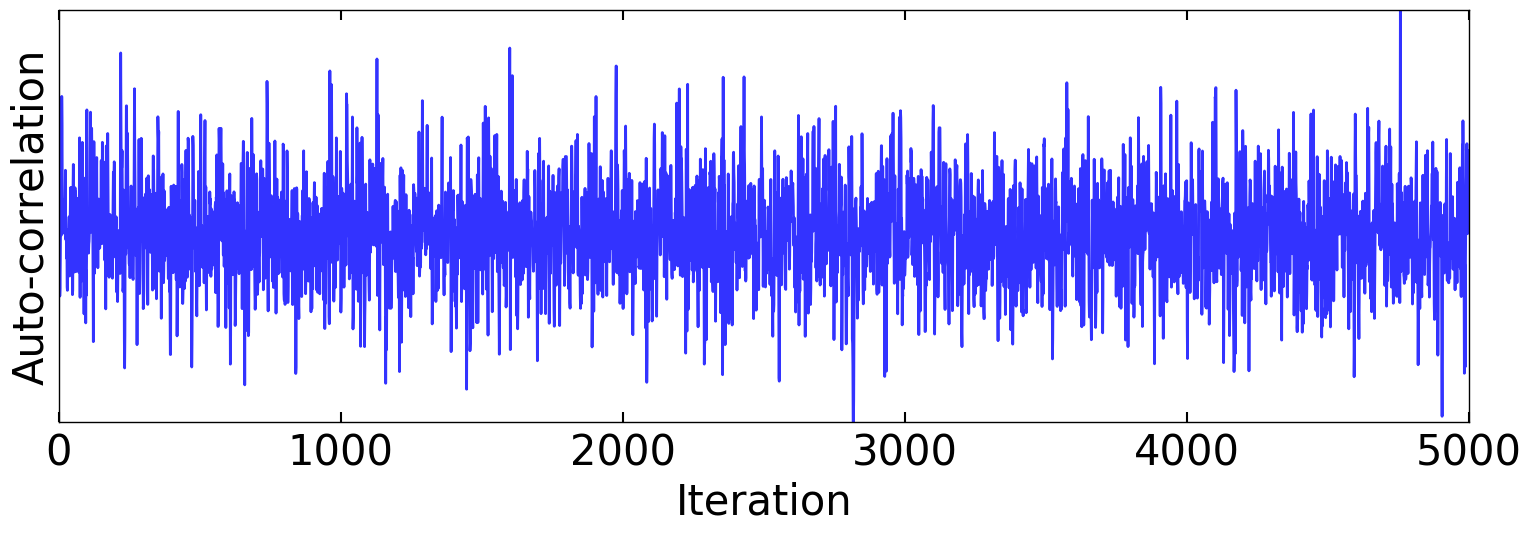

In [225]:
# plot lag=1 autocorrelation
figure(figsize=(16,6))
autocorr = array([correlate(pos_chain[i], pos_chain[i+1]) for i in arange(Nsamples-1)]).flatten()
plot(arange(Nsamples-1), autocorr, lw=2, color='blue', alpha=0.8)
xlabel('Iteration')
ylabel('Auto-correlation')
ylim([autocorr.min(), autocorr.max()])
yticks([])
tight_layout()

Our HMC sampler is also quite efficient at generating independent samples.

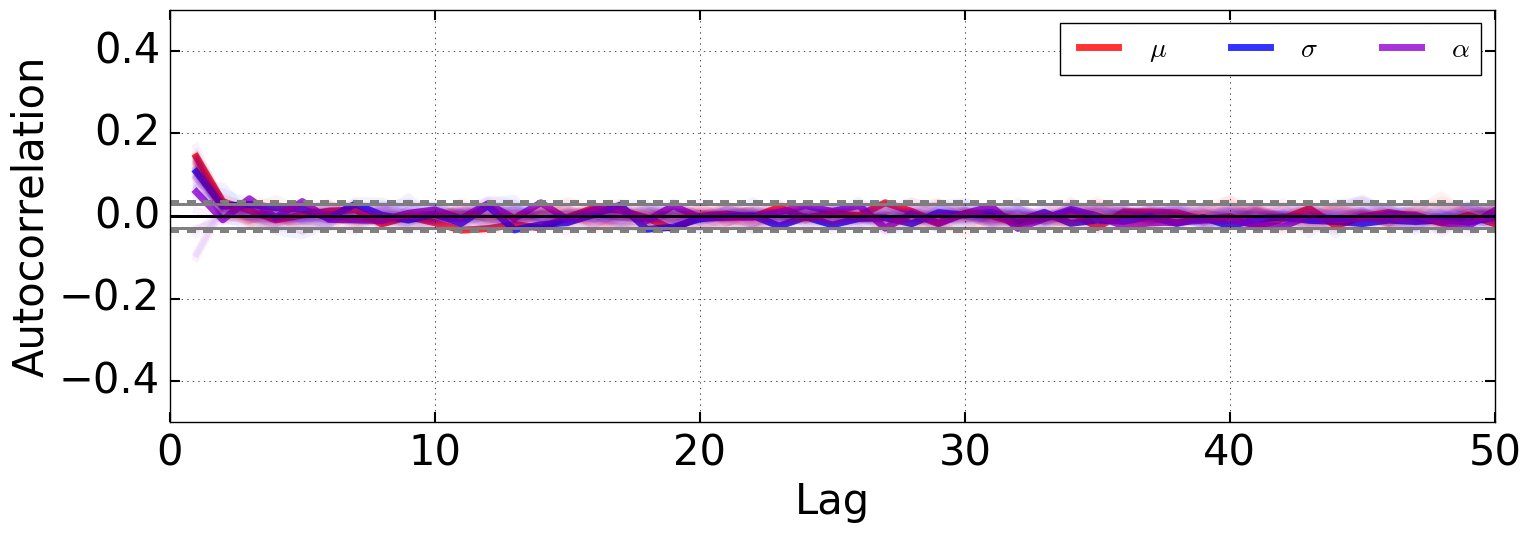

In [226]:
Nburnin = 200 # burn-in
varnames = [r'$\mu$', r'$\sigma$', r'$\alpha$']
varcolors = ['red', 'blue', 'darkviolet']

# plot autocorrelation lag
figure(figsize=(16,6))
h = [autocorrelation_plot(pos_chain[Nburnin:,i], color=varcolors[i], lw=5, alpha=0.8, label=varnames[i])
     for i in xrange(3)]
h = [[autocorrelation_plot(pos_chain[Nburnin:,i+3*j], color=varcolors[i], lw=5, alpha=0.05)
     for i in xrange(3)] for j in xrange(Nlines)]
xlim([0, 50])
ylim([-0.5,0.5])
legend(loc='best', fontsize=20, ncol=Ntheta)
tight_layout()

Let's now examine our samples.

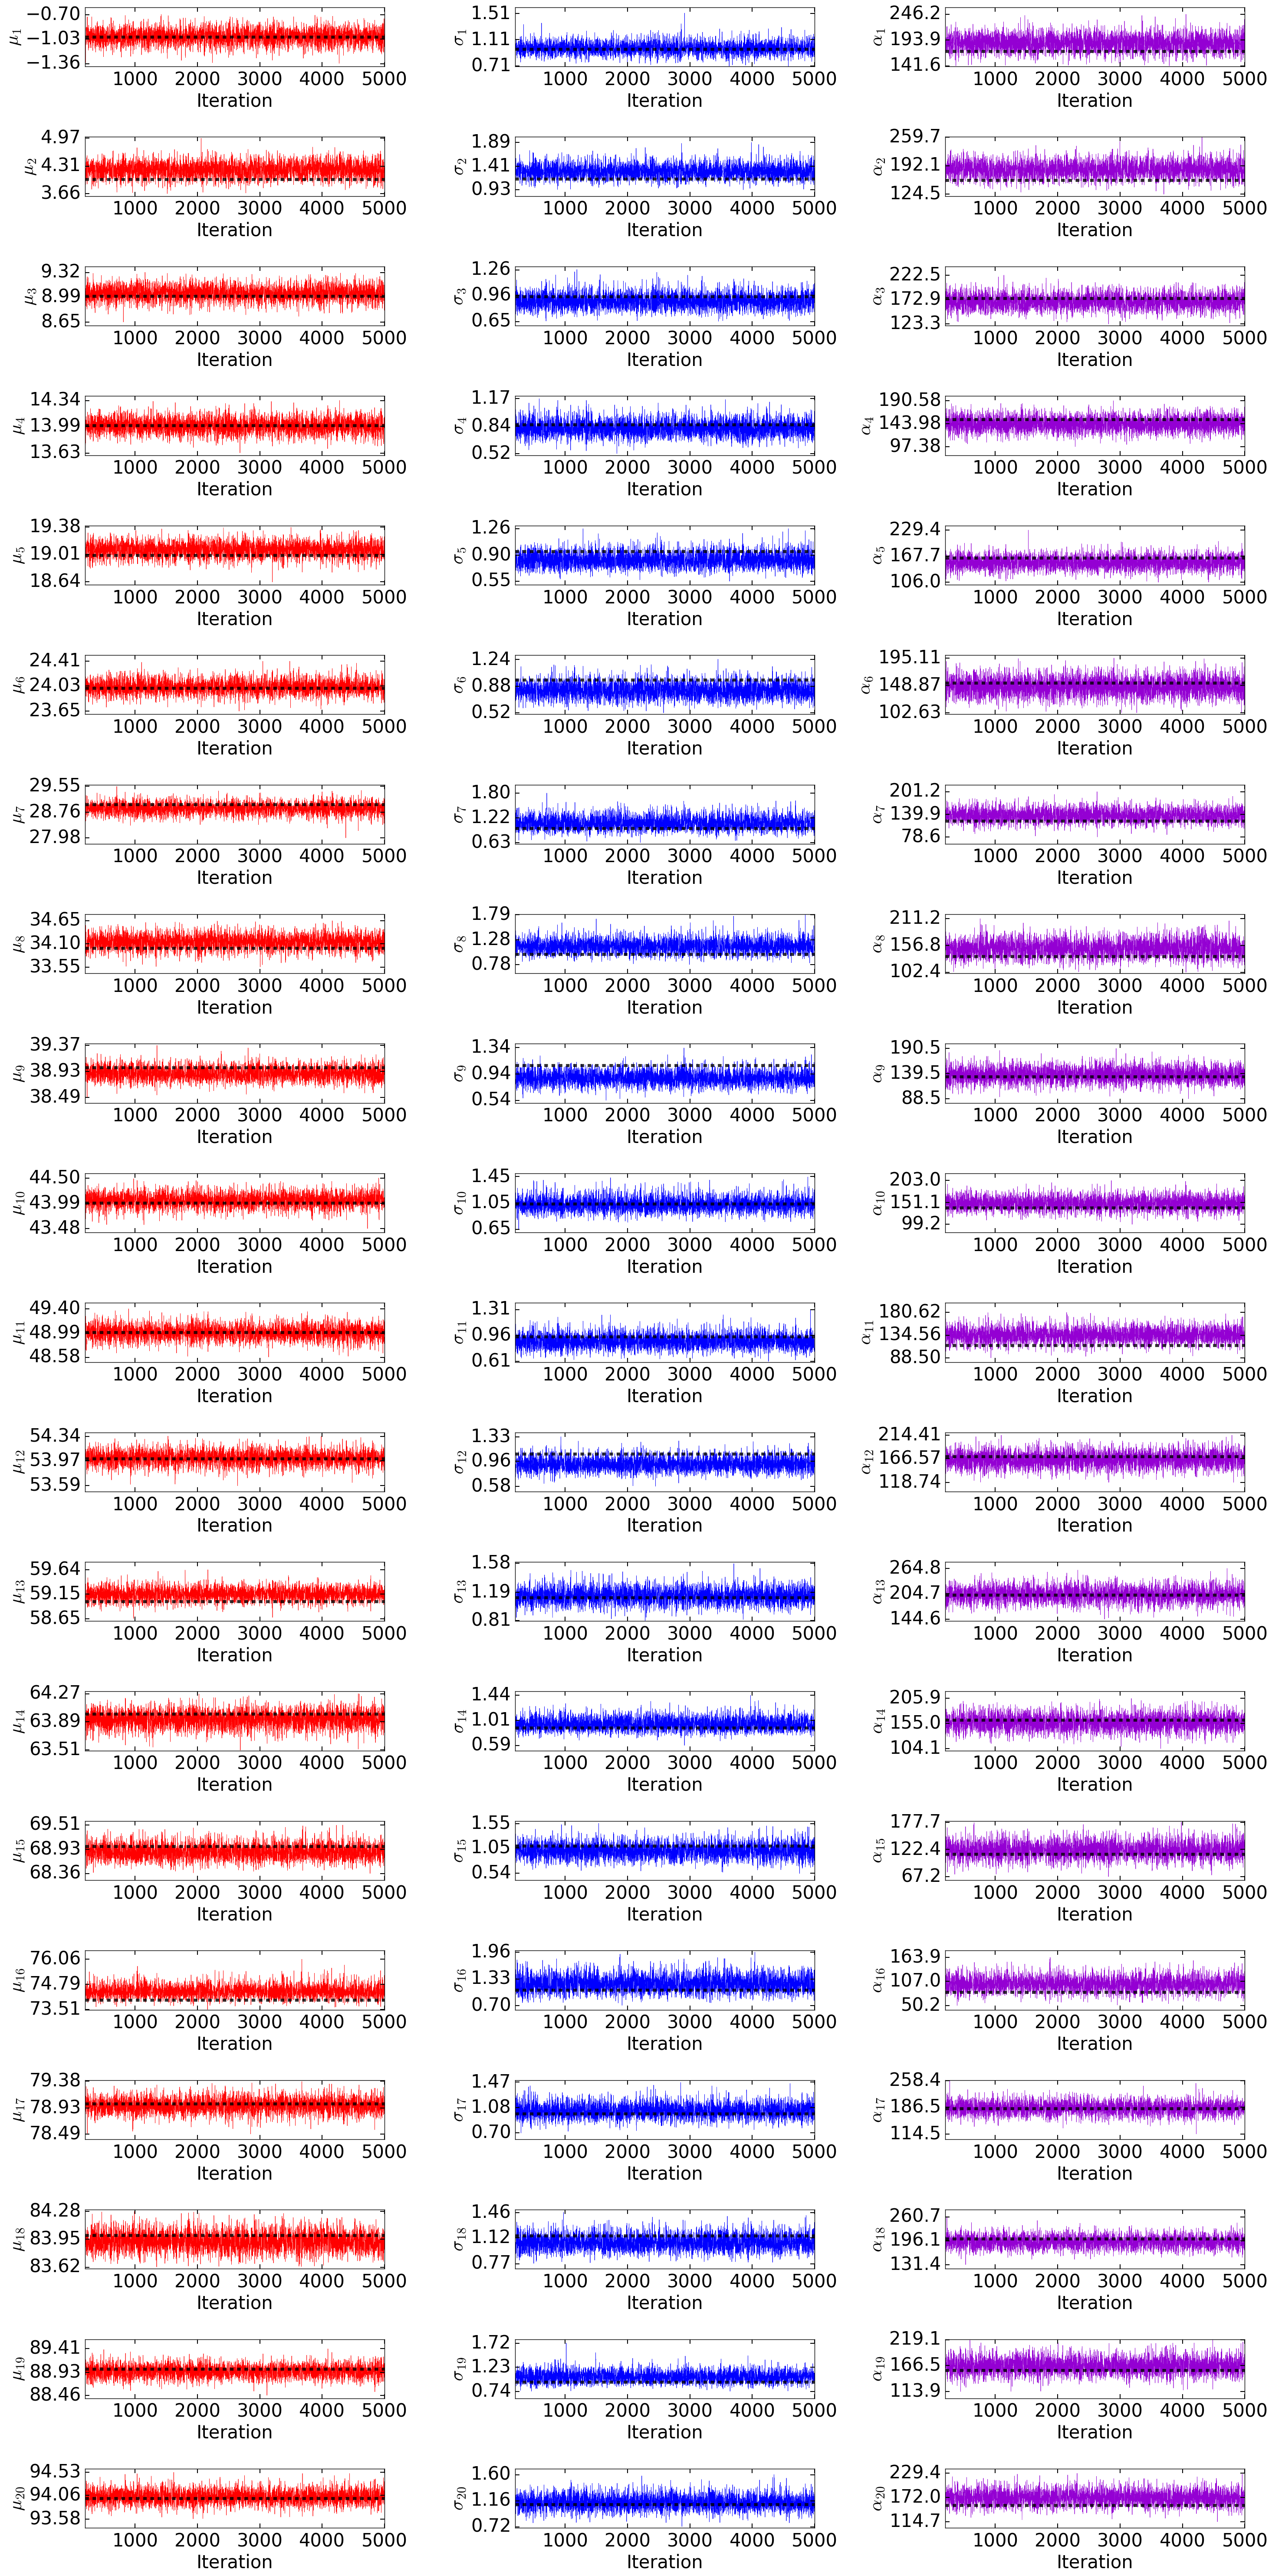

In [227]:
# plot trace
figure(figsize=(30,3*Nlines))
for i in xrange(Nlines):
    for j in xrange(3):
        subplot(Nlines,3,3*i+j+1)
        plot(arange(Nburnin,Nsamples), pos_chain[Nburnin:,3*i+j], lw=0.5, color=varcolors[j], zorder=1)
        hlines(thetas_true[3*i+j], Nburnin, Nsamples, colors='black', linestyles='dashed', lw=5, alpha=0.8, zorder=2)
        ymin, ymax = pos_chain[Nburnin:,3*i+j].min(), pos_chain[Nburnin:,3*i+j].max()
        yticks(linspace(ymin, ymax, 3).round(2))
        xlabel('Iteration')
        xlim([Nburnin, Nsamples])
        ylabel(varnames[j]+'$_{'+str(i+1)+'}$')
        tight_layout()

Now that we are probing a 60-dimensional space, it's a bit challenging to plot up all the results in one place on our corner plot. We'll just focus on one line as an illustrative case.

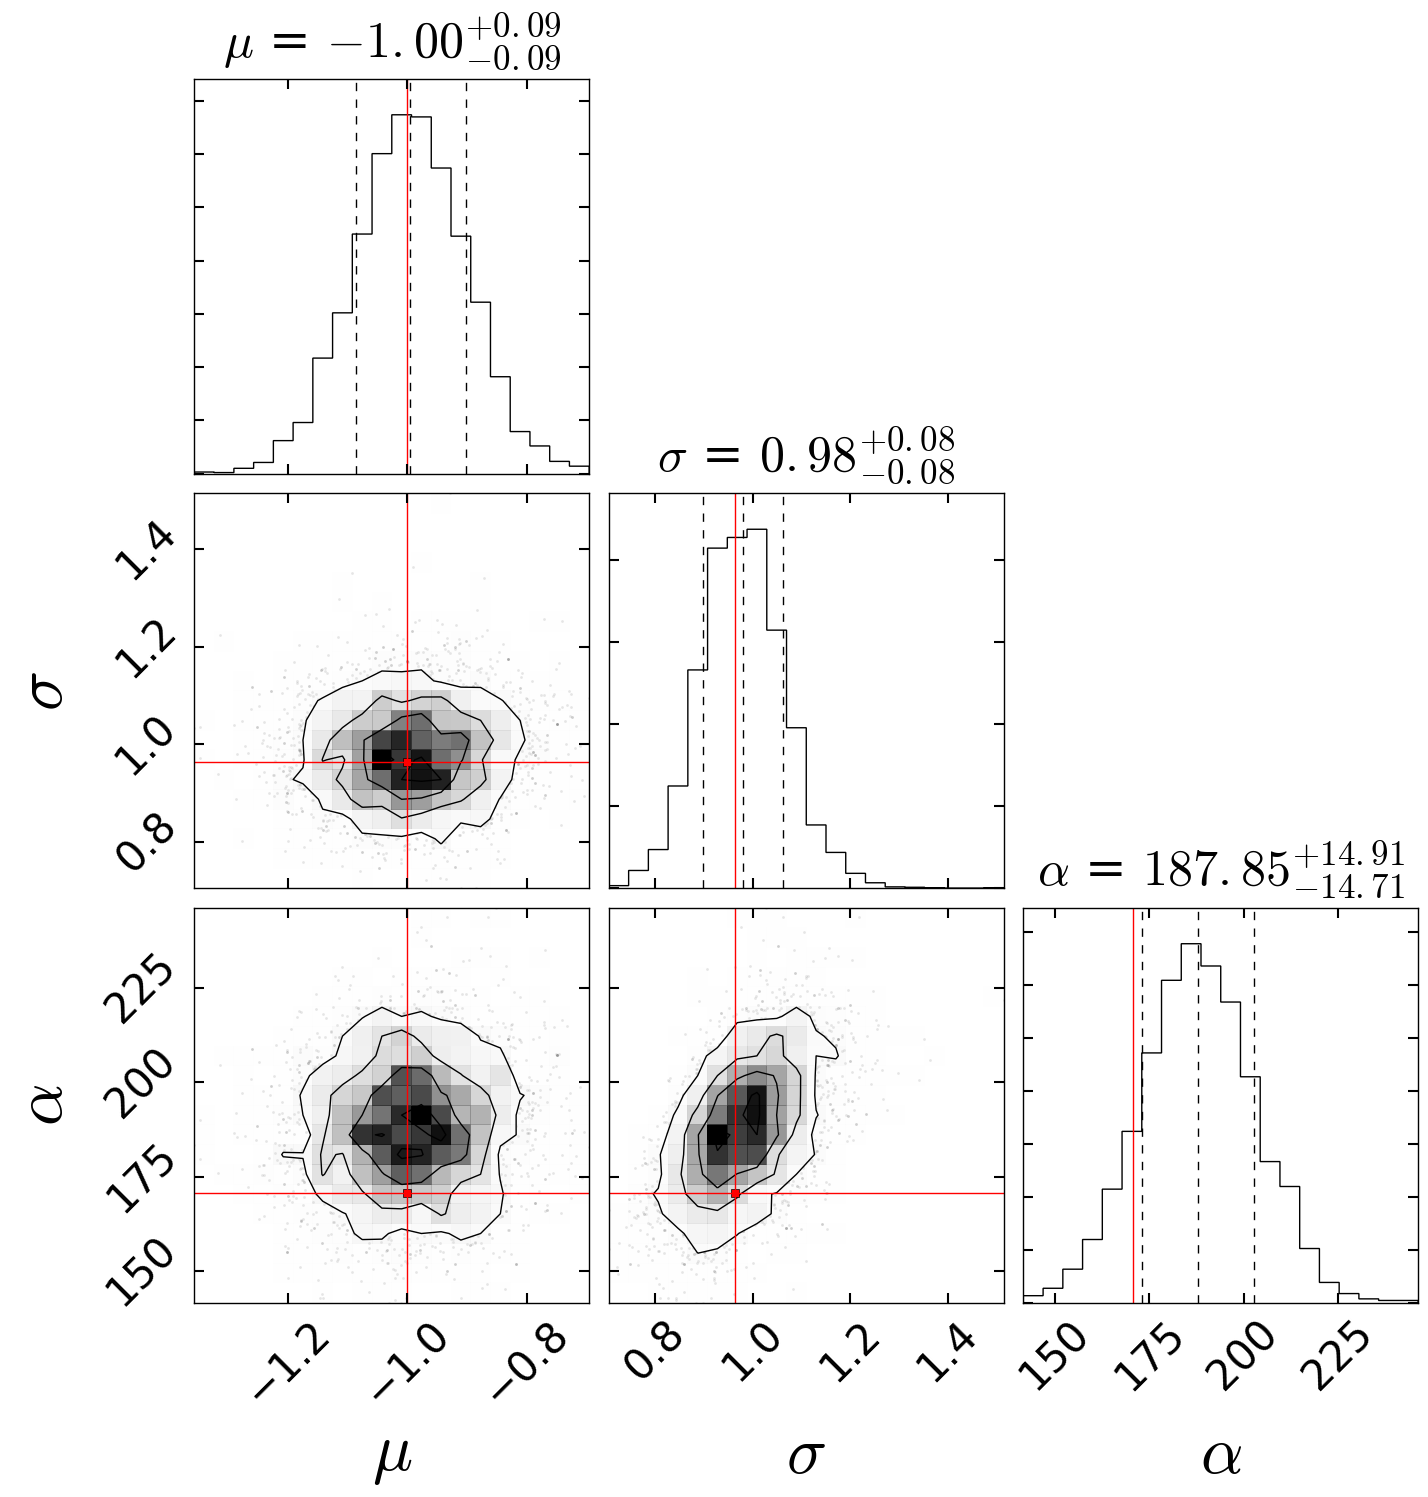

In [228]:
fig = corner.corner(pos_chain[Nburnin:,0:3], quantiles=[.16, .50, .84],
                    labels=varnames, label_kwargs={'fontsize':48}, 
                    truths=thetas_true[0:3], truth_color='red', 
                    show_titles=True, title_kwargs={'y':1.04},
                    fig=subplots(3,3,figsize=(15,15))[0])

Finally, let's see how our fits look relative to the data.

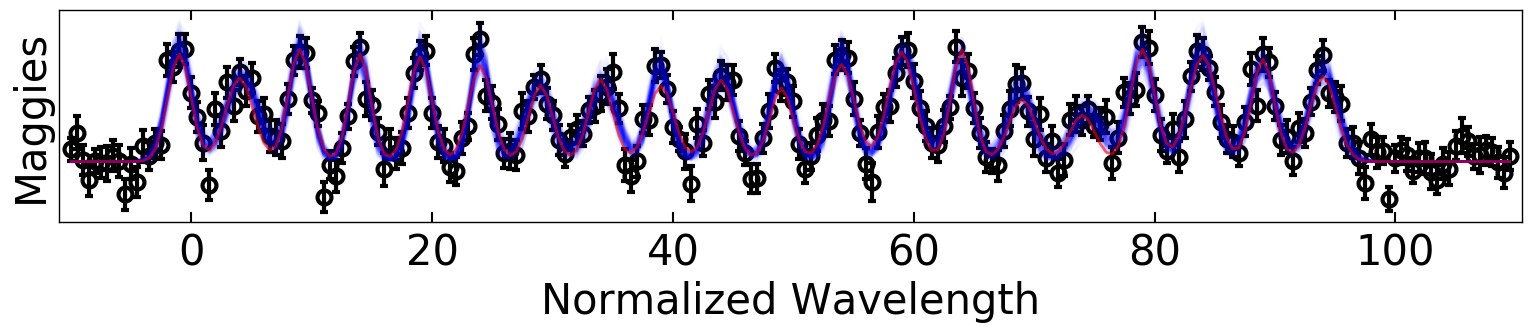

In [229]:
figure(figsize=(16,4))
errorbar(x, y_obs, yerr=y_err, marker='o', markerfacecolor='none', markeredgecolor='black', markeredgewidth=3,
         markersize=10, ecolor='black', lw=3, linestyle='None', zorder=1)
[plot(x, emlines(q), lw=2, alpha=0.02, color='blue', zorder=2) for q in pos_chain[Nburnin::25]]
plot(x, y, lw=2, alpha=0.6, color='red', zorder=3)
xlim([x.min()-1, x.max()+1])
yticks([])
xlabel('Normalized Wavelength')
ylabel('Maggies')
tight_layout()

## Final Note

We have ignored possible covariances among the parameters in this test (i.e. our prior is diagonal), when in reality we expect our means to be very strongly correlated ($\rho(\Delta \mu_i, \Delta \mu_j) \approx 1$), our standard deviations to be moderately correlated ($\rho(\Delta \sigma_i, \Delta \sigma_j) \approx 0.6$ or so?), and our amplitudes to be moderately/weakly correlated ($\rho(\Delta \sigma_i, \Delta \sigma_j) \approx 0.4$ or so?). Physically, this just means that our velocity offsets should be almost identical from line to line (similar gas dynamics), velocity dispersions should be similar among the lines (galaxy kinematics are broadly similar), and the line luminosities trace similar activity (i.e. compared to the prior from model, our galaxy over/under-active).